## **Notebook PC#06**
## Hopfield Network for the Travelling Salesperson Problem (TSP)<BR>
Code based on [this content](https://github.com/ItsWajdy/Hopfield_Network) and on [this content](https://gist.github.com/payoung/6087046). <BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Gabriel Toffanetto França da Rocha - 289320<br>
**Aluno(a):** Maria Fernanda Paulinho Gomes - 206745<br>



In [ ]:
from random import randint
from random import uniform

import numpy as np

def kronecker_delta(x, y):
    if x == y:
        return 1
    return 0

class Hopfield:
    def __init__(self, cities, d, alpha):
        self.cities = cities
        self.neurons = cities**2
        self.d = d
        self.alpha = alpha

        self.w = np.zeros([self.neurons, self.neurons])

        self.x_to_index = {}
        self.index_to_x = {}

        cnt = 0
        for i in range(cities):
            for j in range(cities):
                self.index_to_x[cnt] = (i, j)
                self.x_to_index[(i, j)] = cnt
                cnt += 1

    def train(self, A, B, C, D):
        n = self.cities
        for i in range(n):
            for a in range(n):
                for j in range(n):
                    for b in range(n):
                        wc = -C
                        wa = -A*(1-kronecker_delta(a, b))*kronecker_delta(i, j)
                        wb = -B*(1-kronecker_delta(i, j))*kronecker_delta(a, b)
                        wd = -D*self.d[i][j]*(1-kronecker_delta(i, j))*(kronecker_delta(a-1, b) + kronecker_delta(a+1, b))

                        self.w[self.x_to_index[(i, a)]][self.x_to_index[(j, b)]] = wa + wb + wc + wd

    def predict(self, A, B, C, D, max_iterations):
        self.train(A, B, C, D)

        u = np.zeros([self.neurons, 1])
        for i in range(self.cities):
            for j in range(self.cities):
                u[i][0] = uniform(0, 0.03)

        prev_error = self.calc_error(u, A, B, C, D)
        repeated = 0
        max_repeat = 15
        for iteration in range(max_iterations):
            u = self.update(u, C)
            error = self.calc_error(u, A, B, C, D)
            if error == prev_error:
                repeated += 1
            else:
                repeated = 0

            if repeated > max_repeat:
                break
            prev_error = error
        ret = np.zeros([self.cities, self.cities])
        for i in range(self.cities):
            for j in range(self.cities):
                ret[i][j] = u[self.x_to_index[(i, j)]][0]

        return ret

    def update(self, u, C):
        # update is done asynchronously
        # to make update synchronous replace C*(n+1) with a bias vector containing C*(n+sigma)
        n = self.cities
        for iteration in range(5*n**2):
            i = randint(0, n-1)
            x = randint(0, n-1)
            u[self.x_to_index[(i, x)]][0] = self.f(np.dot(u.transpose(), self.w[:, self.x_to_index[(i, x)]]) + C*(n+1))
        return u

    def f(self, x):
        return 0.5*(1+np.tanh(self.alpha*x))

    def calc_error(self, u, A, B, C, D):
        tmpA = 0
        n = self.cities
        for i in range(n):
            for a in range(n):
                for b in range(n):
                    if a != b:
                        tmpA += u[self.x_to_index[(i, a)]][0] * u[self.x_to_index[(i, b)]][0]
        tmpA *= (A/2.0)

        tmpB = 0
        for i in range(n):
            for j in range(n):
                for a in range(n):
                    if i != j:
                        tmpB += u[self.x_to_index[(i, a)]][0] * u[self.x_to_index[(j, a)]][0]
        tmpB *= (B/2.0)

        tmpC = 0
        for i in range(n):
            for a in range(n):
                tmpC += u[self.x_to_index[(i, a)]][0]
        tmpC = (tmpC - n)**2
        tmpC *= (C/2.0)

        tmpD = 0
        for i in range(n):
            for j in range(n):
                for a in range(n):
                    if 0 < a < n-1:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a+1)]][0] + u[self.x_to_index[(j, a-1)]][0])
                    elif a > 0:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a-1)]][0] + u[self.x_to_index[(j, 0)]][0])
                    elif a < n-1:
                        tmpD += self.d[i][j]*u[self.x_to_index[(i, a)]][0]*(u[self.x_to_index[(j, a+1)]][0] + u[self.x_to_index[(j, n-1)]][0])
        tmpD *= (D/2.0)

        return tmpA + tmpB + tmpC + tmpD

In [ ]:
import matplotlib.pyplot as plt

def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(50)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(0, max(x)*1.1)
    plt.ylim(0, max(y)*1.1)
    plt.show()

Iteration: 0


<ipython-input-1-6a13b945a6a7>:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[self.x_to_index[(i, x)]][0] = self.f(np.dot(u.transpose(), self.w[:, self.x_to_index[(i, x)]]) + C*(n+1))


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


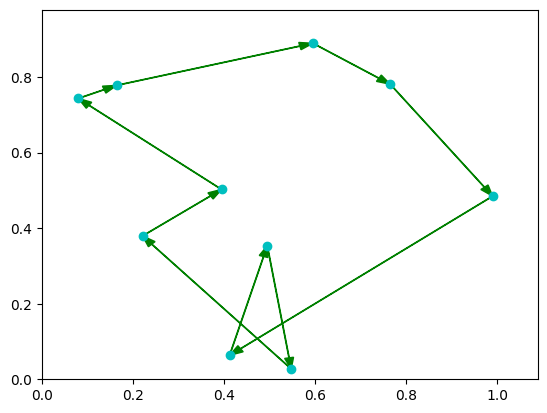

[8 1 4 3 0 6 7 9 5 2]
Distance: 3.5452343339117802 

Iteration: 1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


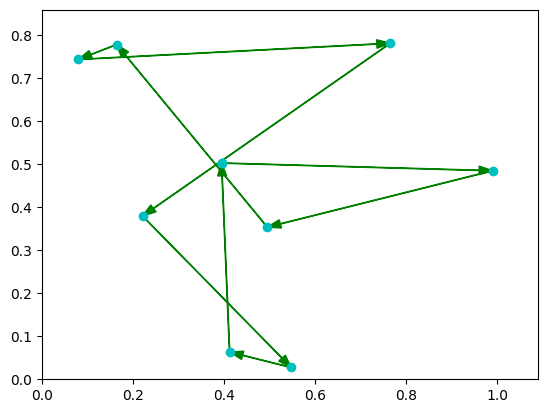

[2 1 7 6 5 3 4 8 0 0]
Distance: 2003.8377412096986 

Iteration: 2
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


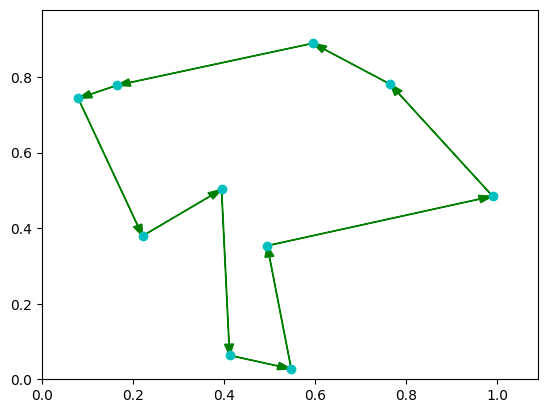

[2 5 9 7 6 3 0 8 4 1]
Distance: 3.133978024538095 

Iteration: 3
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]]


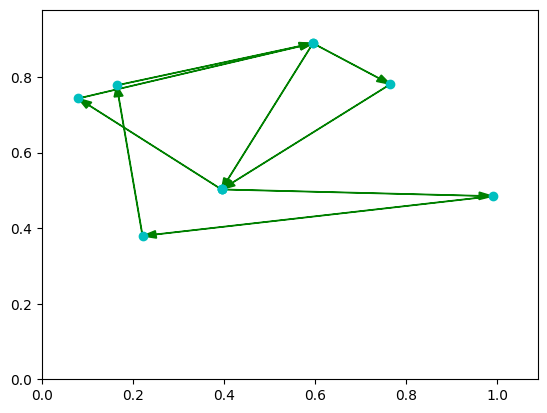

[6 9 5 0 2 3 7 9 0 0]
Distance: 2003.9547251969302 

Iteration: 4
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


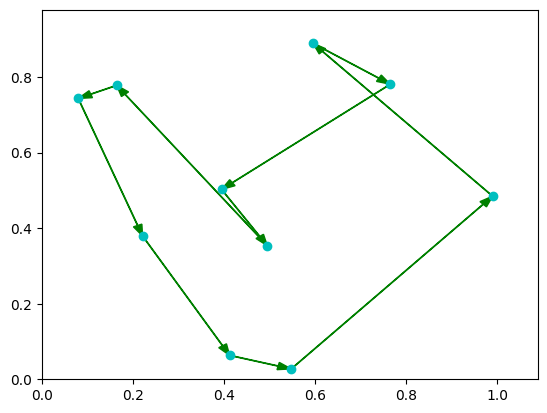

[9 5 0 1 7 6 3 8 4 2]
Distance: 3.5741533789407356 

Iteration: 5
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


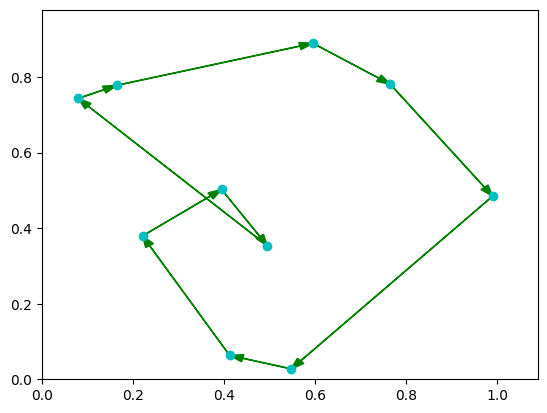

[9 5 2 4 8 3 0 1 6 7]
Distance: 3.216433269445325 

Iteration: 6
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


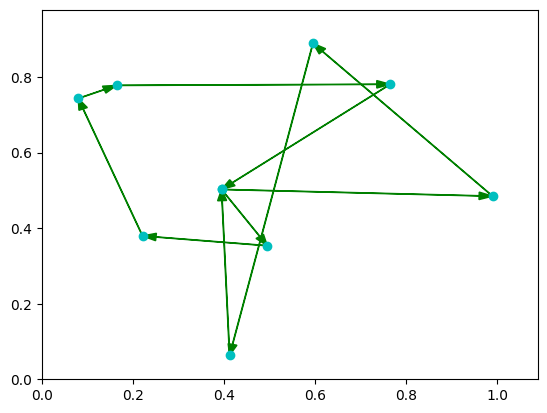

[2 9 8 0 1 3 6 7 5 0]
Distance: 1003.7591210642058 

Iteration: 7
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


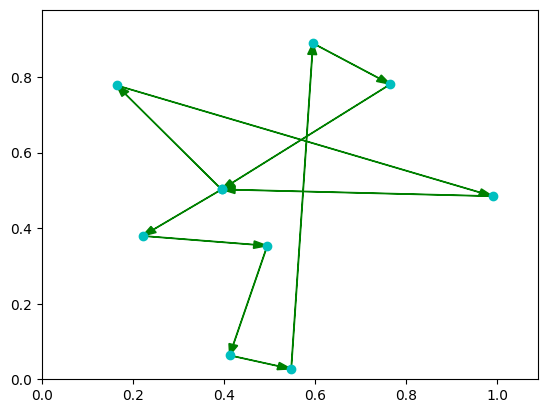

[7 2 0 3 1 8 4 9 5 0]
Distance: 1004.066083502899 

Iteration: 8
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


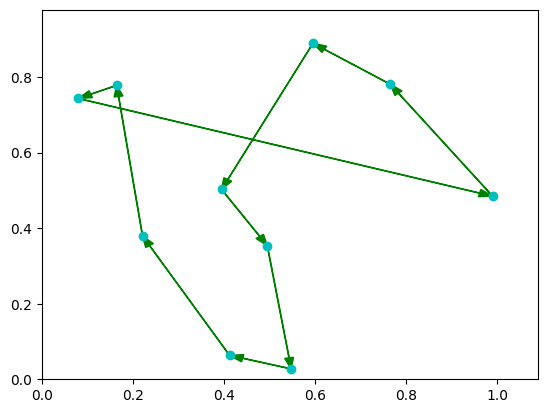

[2 5 9 0 1 4 8 3 7 6]
Distance: 3.467621364156878 

Iteration: 9
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


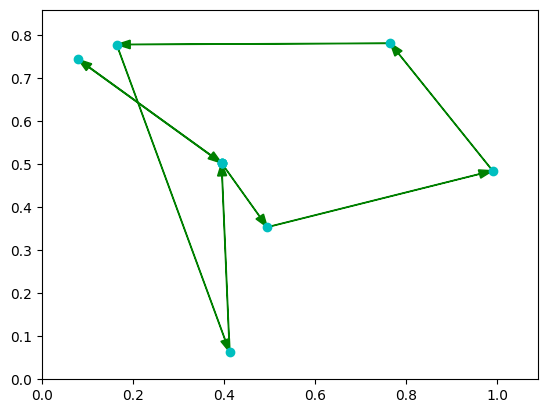

[6 0 1 2 5 7 8 0 0 0]
Distance: 3003.5730571408953 

Iteration: 10
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


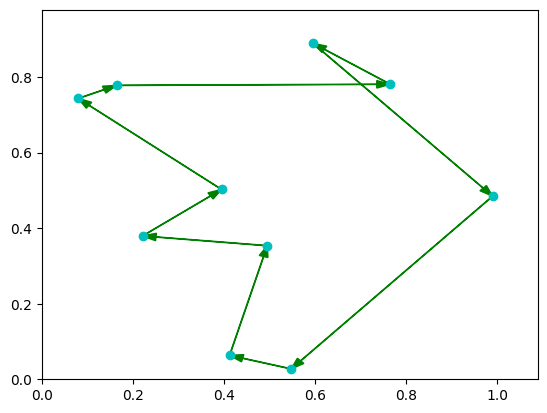

[4 8 1 3 0 6 7 5 9 2]
Distance: 3.420126213140615 

Iteration: 11
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


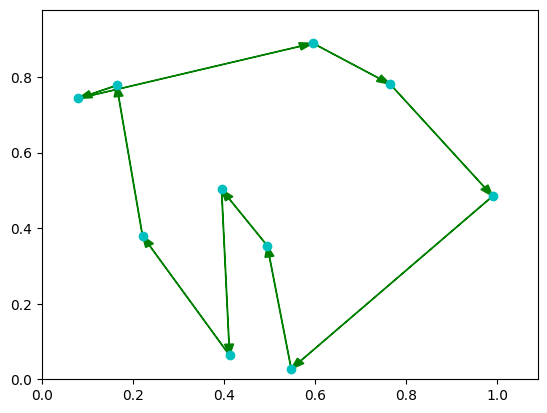

[4 1 0 8 3 7 6 9 5 2]
Distance: 3.5572008600692753 

Iteration: 12
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


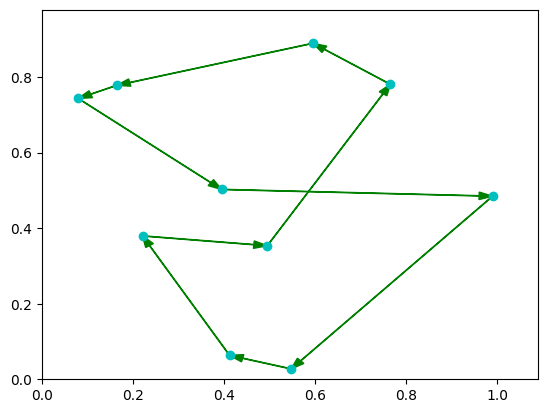

[2 4 8 3 1 5 9 7 6 0]
Distance: 3.655114676657073 

Iteration: 13
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


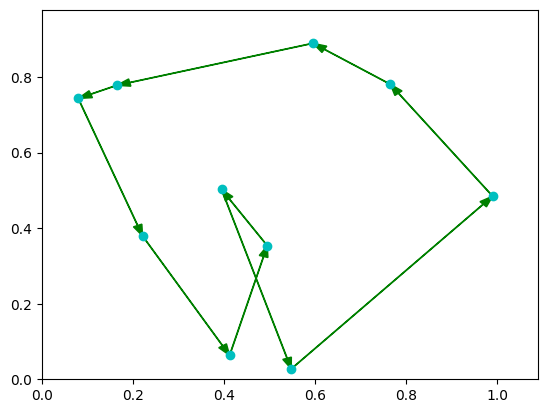

[2 5 9 7 6 3 8 1 0 4]
Distance: 3.4854866726507057 

Iteration: 14
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


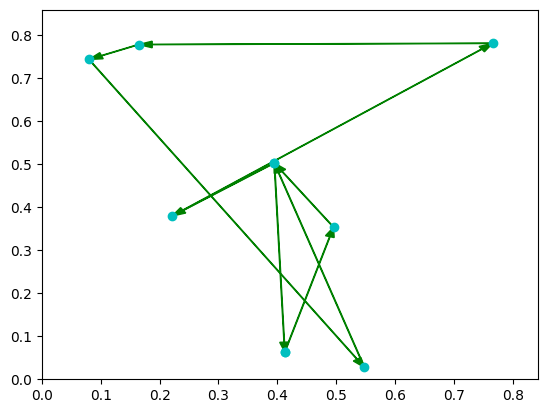

[3 5 7 6 4 0 8 8 1 0]
Distance: 1003.7381750003445 

Iteration: 15
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


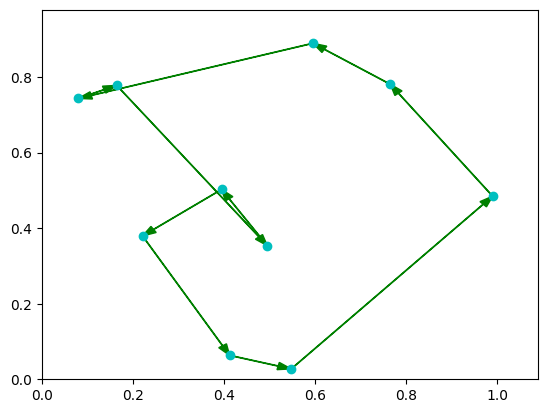

[5 9 6 7 1 0 3 8 4 2]
Distance: 3.2755780760541287 

Iteration: 16
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


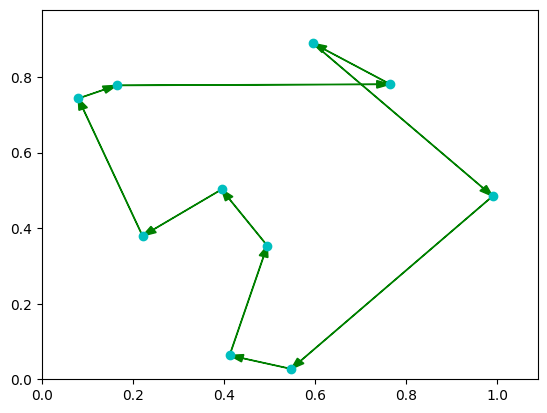

[2 4 8 1 0 3 6 7 5 9]
Distance: 3.3187140699152593 

Iteration: 17
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


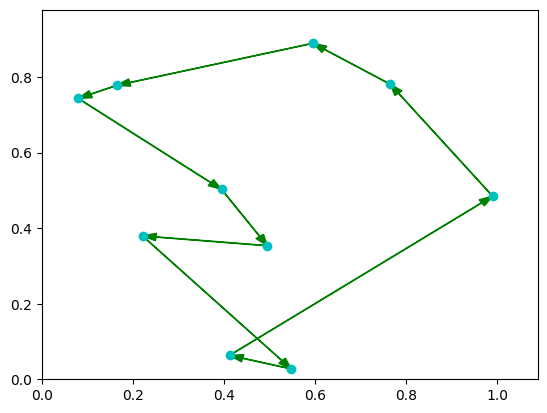

[2 5 9 7 6 0 1 3 4 8]
Distance: 3.295152703937273 

Iteration: 18
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


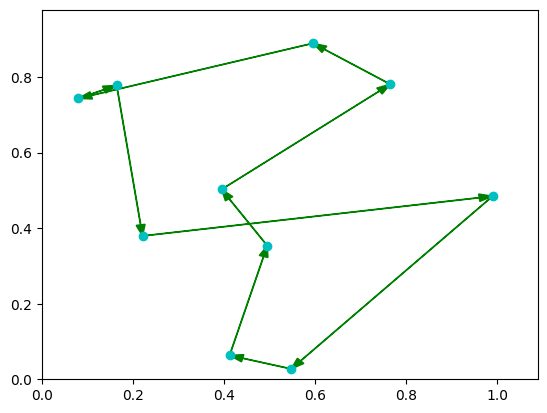

[2 4 8 1 0 5 9 6 7 3]
Distance: 3.727175822153874 

Iteration: 19
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


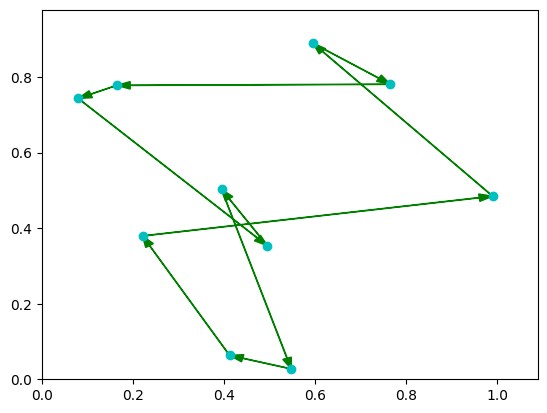

[2 9 5 7 6 1 0 4 8 3]
Distance: 3.9913634007621304 

Iteration: 20
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


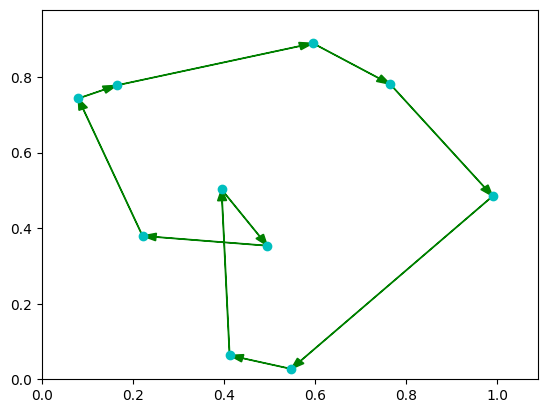

[4 8 0 1 3 6 7 9 5 2]
Distance: 3.1699266050239165 

Iteration: 21
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


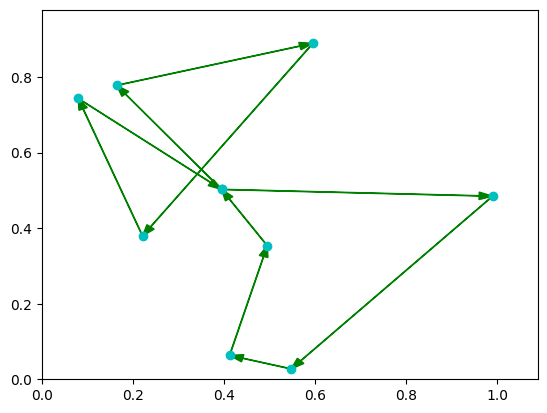

[2 4 8 1 0 7 9 3 6 0]
Distance: 1004.0299454591212 

Iteration: 22
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


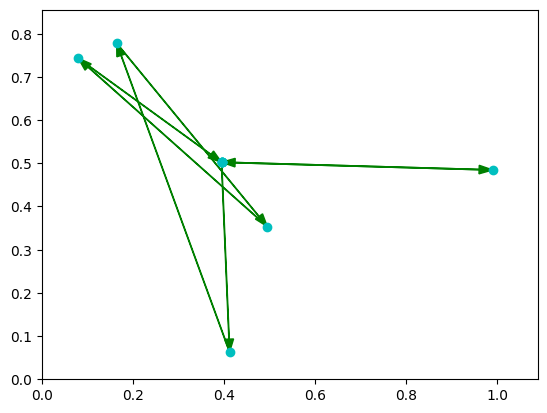

[2 0 8 7 1 6 0 0 0 0]
Distance: 4003.844199143986 

Iteration: 23
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


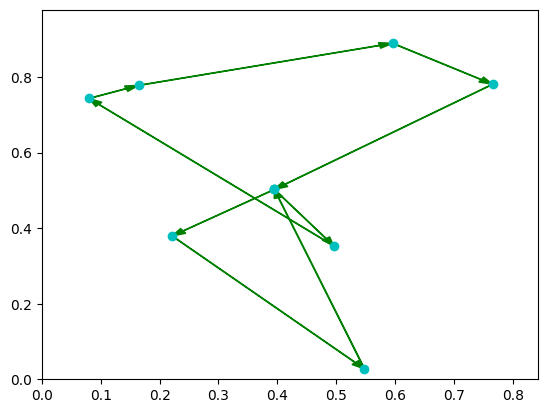

[1 6 7 9 5 0 3 4 0 0]
Distance: 2002.7933566115626 

Iteration: 24
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


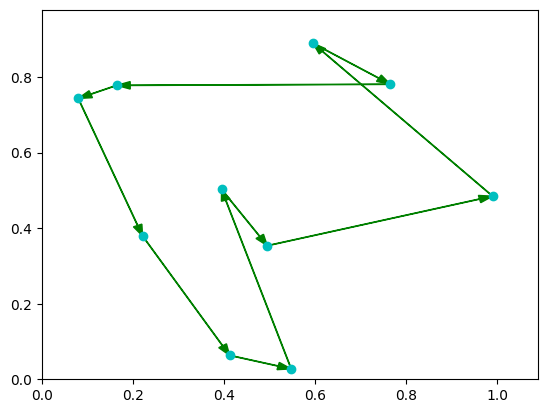

[9 5 7 6 3 8 4 0 1 2]
Distance: 3.548336969502589 

Iteration: 25
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


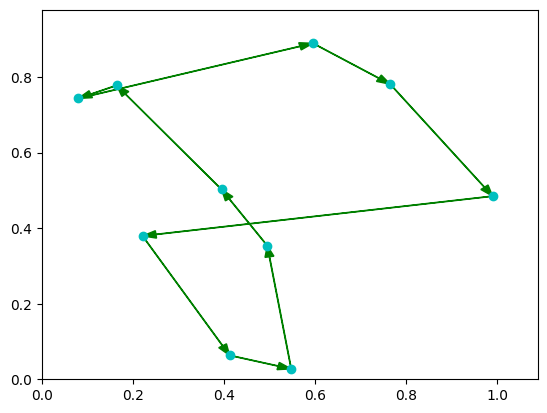

[3 8 4 1 0 7 6 9 5 2]
Distance: 3.3539271606427614 

Iteration: 26
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


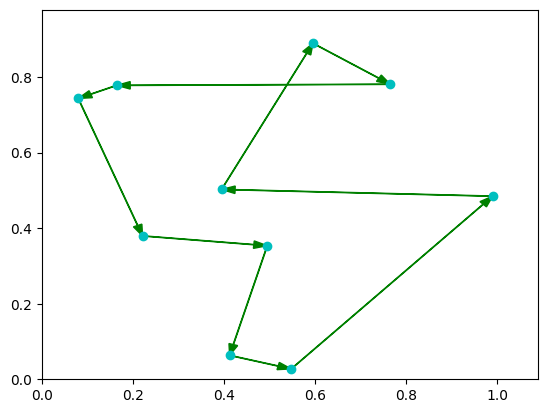

[0 9 5 7 6 3 1 8 4 2]
Distance: 3.6675458928776576 

Iteration: 27
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


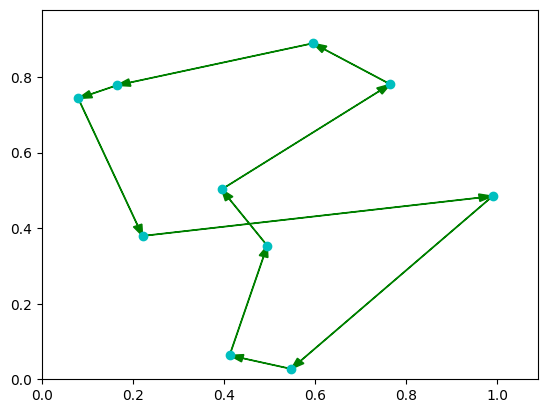

[2 4 8 1 0 5 9 7 6 3]
Distance: 3.6244358942814663 

Iteration: 28
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


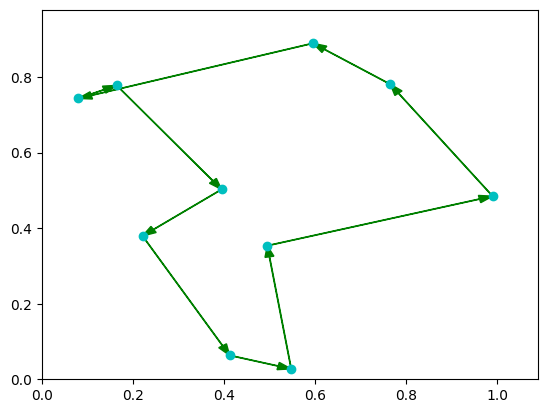

[2 5 9 6 7 0 3 8 4 1]
Distance: 3.1230477390270512 

Iteration: 29
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


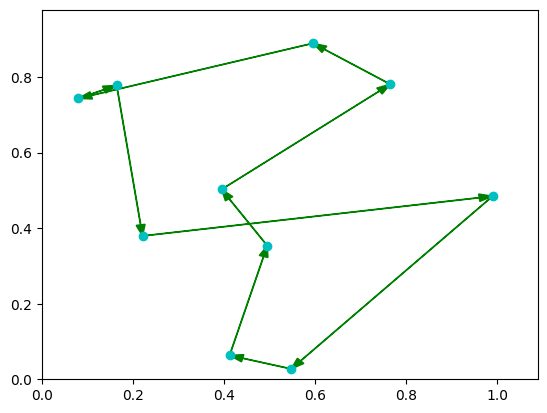

[2 4 8 1 0 5 9 6 7 3]
Distance: 3.727175822153874 

Iteration: 30
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


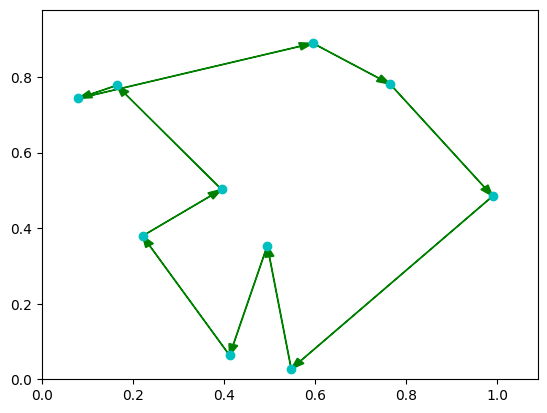

[4 1 8 3 0 7 6 9 5 2]
Distance: 3.4090779494873793 

Iteration: 31
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


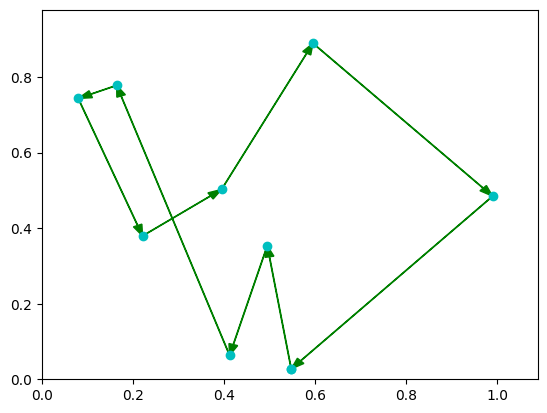

[7 6 3 0 9 2 4 4 1 8]
Distance: 3.7193600088554453 

Iteration: 32
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


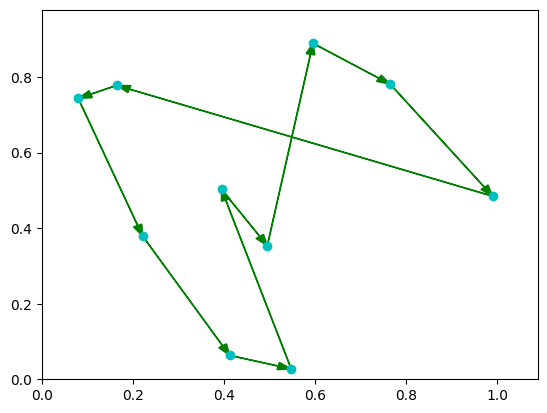

[7 6 3 8 4 0 1 9 5 2]
Distance: 3.6635158602130247 

Iteration: 33
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


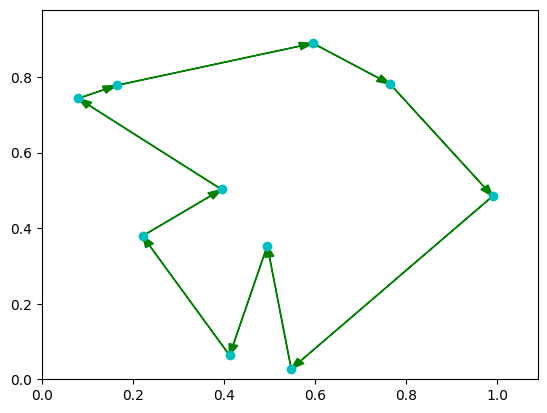

[4 1 8 3 0 6 7 9 5 2]
Distance: 3.3557800330013547 

Iteration: 34
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


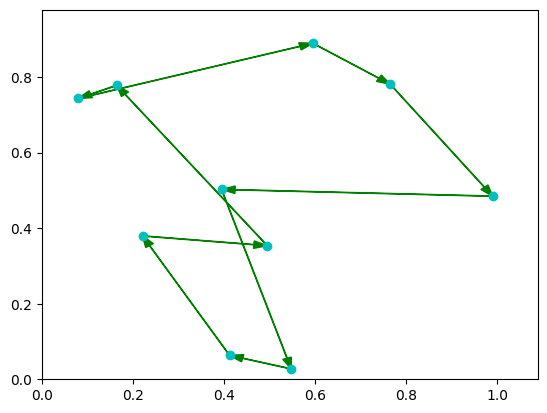

[0 4 8 3 1 7 6 9 5 2]
Distance: 3.616734147899063 

Iteration: 35
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


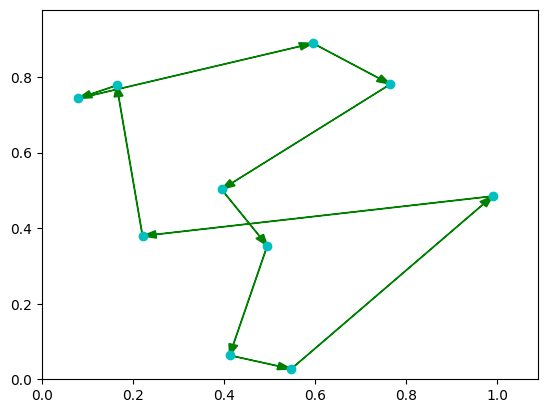

[3 7 6 9 5 0 1 8 4 2]
Distance: 3.7271758221538733 

Iteration: 36
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


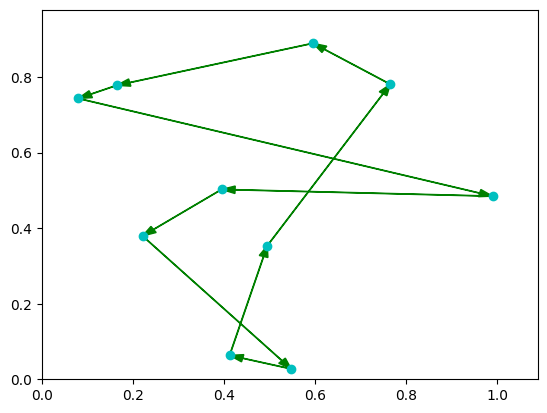

[2 0 3 4 8 1 5 9 7 6]
Distance: 3.9187481114434717 

Iteration: 37
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


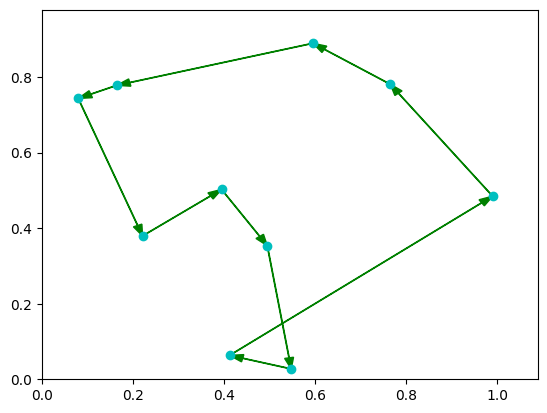

[2 5 9 7 6 3 0 1 4 8]
Distance: 3.0771391156544454 

Iteration: 38
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


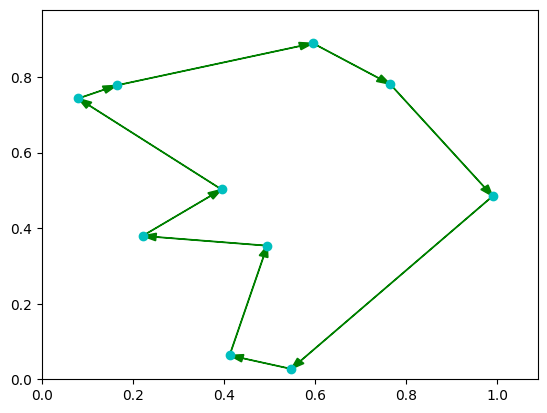

[2 4 8 1 3 0 6 7 9 5]
Distance: 3.071245705828405 

Iteration: 39
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


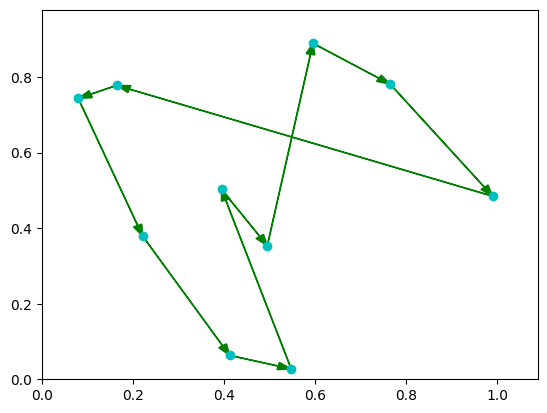

[7 6 3 8 4 0 1 9 5 2]
Distance: 3.6635158602130247 

Iteration: 40
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


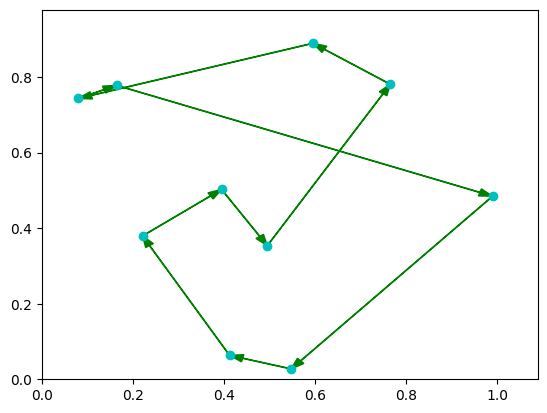

[2 4 8 3 0 1 5 9 6 7]
Distance: 3.747197493257999 

Iteration: 41
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


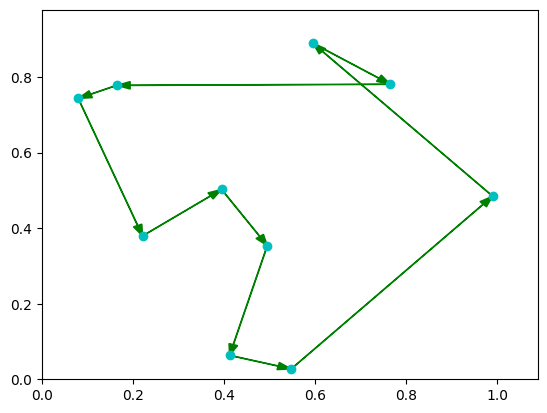

[2 9 5 7 6 3 0 1 8 4]
Distance: 3.3187140699152584 

Iteration: 42
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


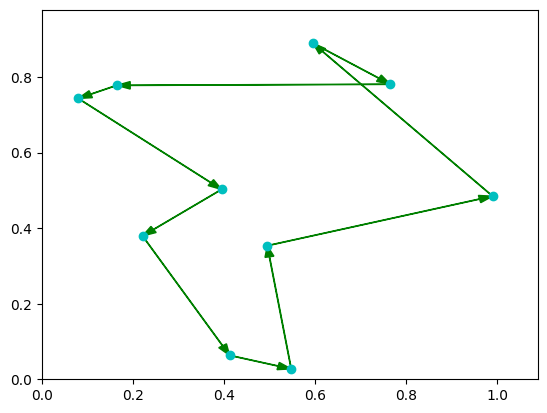

[2 9 5 7 6 0 3 8 4 1]
Distance: 3.418630329853237 

Iteration: 43
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


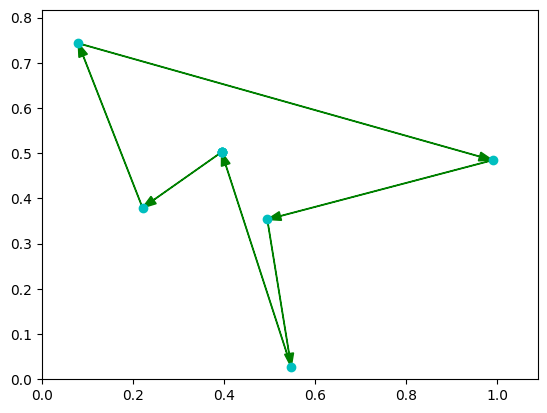

[0 3 6 2 1 4 0 0 0 0]
Distance: 4002.88981854098 

Iteration: 44
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


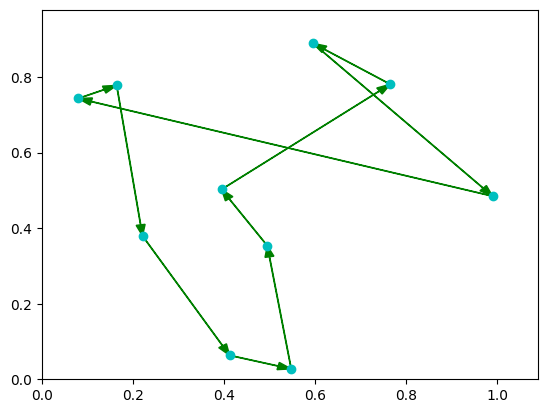

[6 7 3 8 4 1 0 5 9 2]
Distance: 3.6884983207132347 

Iteration: 45
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


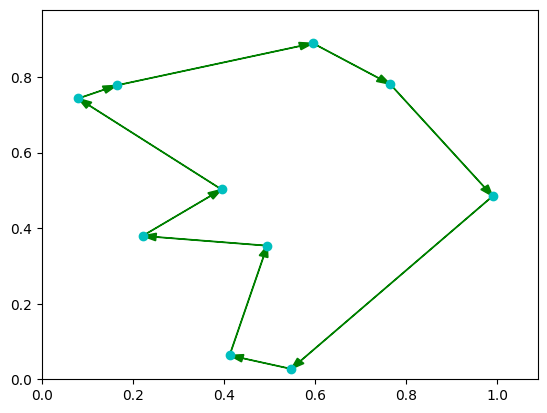

[2 4 8 1 3 0 6 7 9 5]
Distance: 3.071245705828405 

Iteration: 46
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


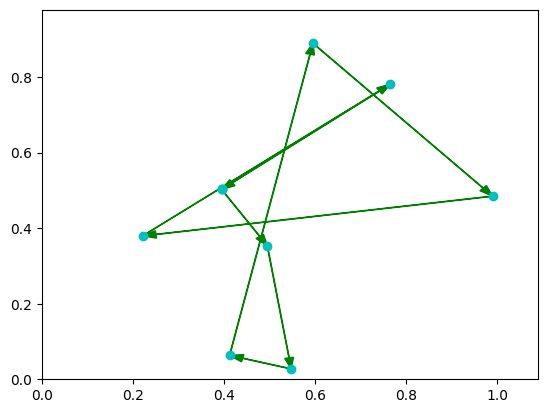

[0 1 4 8 9 2 3 5 0 0]
Distance: 2003.9759427888287 

Iteration: 47
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


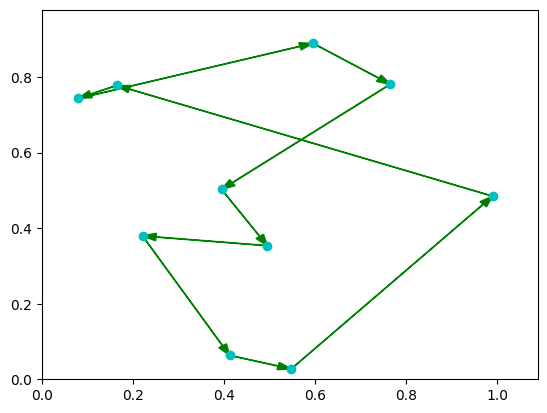

[7 6 9 5 0 1 3 8 4 2]
Distance: 3.767489999146531 

Iteration: 48
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


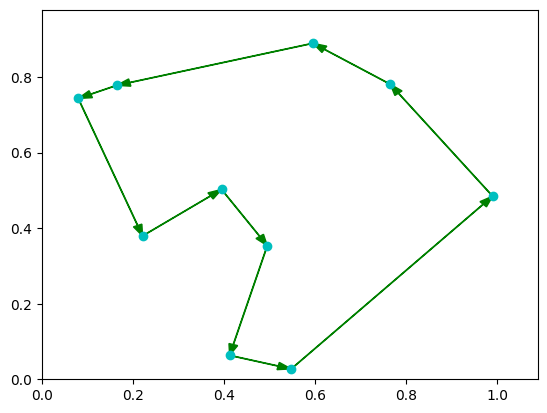

[5 9 7 6 3 0 1 8 4 2]
Distance: 2.969833562603048 

Iteration: 49
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


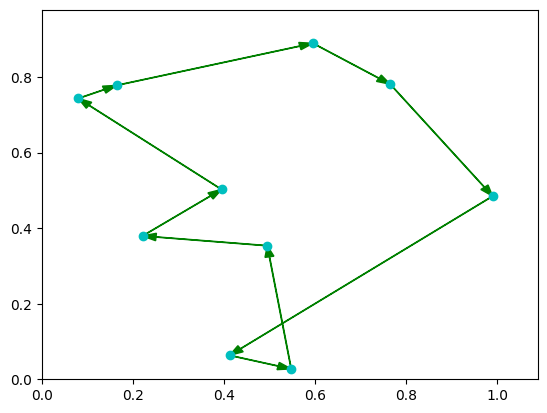

[8 4 1 3 0 6 7 9 5 2]
Distance: 3.1785512588798013 


Min: 2.969833562603048
Max: 4003.844199143986


In [ ]:
import numpy as np

def calc_d(cities):
	n = cities.shape[0]
	d = np.zeros([n, n])
	for i in range(n):
		for j in range(n):
			d[i][j] = np.sqrt(np.square(cities[i][0] - cities[j][0]) + np.square(cities[i][1] - cities[j][1]))
	return d

def calc_dist_route(cities):
  n = cities.shape[0]
  d = 0
  for i in range(n-1):
    d += np.sqrt(np.square(cities[i][0] - cities[i+1][0]) + np.square(cities[i][1] - cities[i+1][1]))
  d += np.sqrt(np.square(cities[n-1][0] - cities[0][0]) + np.square(cities[n-1][1] - cities[0][1]))
  return d

def set_cities(mode,n):
	city = np.zeros([n, 2])
	if mode == 1:
		city[0] = (0.06, 0.70)
		city[1] = (0.08, 0.90)
		city[2] = (0.22, 0.67)
		city[3] = (0.30, 0.20)
		city[4] = (0.35, 0.95)
		city[5] = (0.40, 0.15)
		city[6] = (0.50, 0.75)
		city[7] = (0.62, 0.70)
		city[8] = (0.70, 0.80)
		city[9] = (0.83, 0.20)
	elif mode == 2:
		city[0] = (0.025, 0.125)
		city[1] = (0.150, 0.750)
		city[2] = (0.125, 0.225)
		city[3] = (0.325, 0.550)
		city[4] = (0.500, 0.150)
		city[5] = (0.625, 0.500)
		city[6] = (0.700, 0.375)
		city[7] = (0.875, 0.400)
		city[8] = (0.900, 0.425)
		city[9] = (0.925, 0.700)
	elif mode == 3:
		city[0] = (0.25, 0.16)
		city[1] = (0.85, 0.35)
		city[2] = (0.65, 0.24)
		city[3] = (0.70, 0.50)
		city[4] = (0.15, 0.22)
		city[5] = (0.25, 0.78)
		city[6] = (0.40, 0.45)
		city[7] = (0.90, 0.65)
		city[8] = (0.55, 0.90)
		city[9] = (0.60, 0.25)
	elif mode == 4:
		city = np.array([[0.39483265, 0.50242079],
       [0.49523524, 0.35349841],
       [0.98993043, 0.48457834],
       [0.22134867, 0.37933196],
       [0.54776891, 0.02742277],
       [0.76523794, 0.78075363],
       [0.08019347, 0.74317798],
       [0.16455042, 0.77782448],
       [0.41247276, 0.06330139],
       [0.59550737, 0.88921593]])
	else:
		city = np.random.rand(n, 2)
	return city

n = 10 # For options 1 to 4, please choose n = 10
city = set_cities(4,n)
d = calc_d(city)

mini = 1000
maxi = -1
max_it = 50 # Please, set the maximum number of iterations here
mini_def = mini
for iteration in range(max_it):
  print("Iteration:", iteration)
  hp = Hopfield(n, d, 50.0)
  v = hp.predict(A=100.0, B=100.0, C=90.0, D=110.0, max_iterations=500)
  print(v)

  dist = 0
  prev_row = -1
  route = np.zeros(n)
  ind = 0
  for col in range(v.shape[1]):
    if [max(i) for i in zip(*v)][col] < 1.0:
      dist += 1000
    for row in range(v.shape[0]):
      if v[row][col] == 1:
        if prev_row != -1:
          dist += d[prev_row][row]
          # print("From City {} To City {}".format(prev_row + 1, row + 1))
        else:
          row_ini = row
        prev_row = row
        route[ind] = row
        ind += 1
        break
  dist += d[row][row_ini]
  mini = min(mini, dist)
  if mini < mini_def:
    mini_def = mini
    iteration_def = iteration
    route_def = route
  maxi = max(maxi, dist)
  plotTSP(route.astype(int), city, 1)
  print(route.astype(int))
  plt.show()
  print("Distance:", dist, "\n")
print("\nMin: {}\nMax: {}".format(mini, maxi))

Execute a célula acima para ao menos 2 das instâncias disponíveis. Para cada execução, apresente o melhor resultado usando o par de células a seguir.

# **Resultados para o Caso de Estudo 1**

Cidade da instância 2 (mode = 2)

> Dentre as interações, observa-se que há oscilação dos valores de distância total numa faixa de aproximadamente 0,8 unidades de distância, logo o problema consegue ser resolvido com certa estabilidade, ao redor de um ponto, o que indica a existência de uma condição inical que leva para um mínimo local de boa qualidade. Porém executando várias vezes, observa-se distâncias que explodem, mostrando que para tal execução, houveram condições iniciais de baixa qualidade.

Exemplo de máximo e mínimo:

```
Min: 2.862426520674166
Max: 3.955720677985809
```



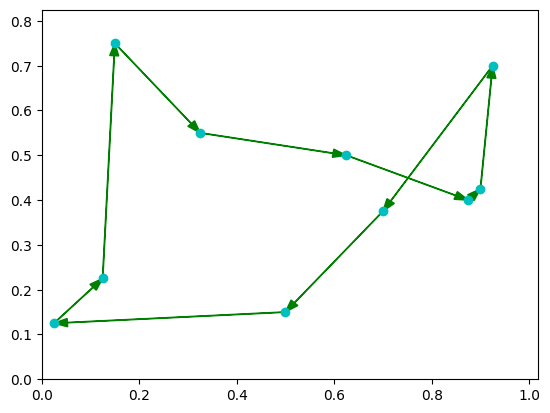

2.989637645708903

In [ ]:
plotTSP(route_def.astype(int), city, 1)
calc_dist_route(city[route_def.astype(int)])

In [ ]:
route_def.astype(int)

array([0, 2, 1, 3, 5, 7, 8, 9, 6, 4])

# **Resultados para o Caso de Estudo 2**

Cidade da instância 4 (mode = 4)

> Houveram iterações onde a distância total percorrida chegou a mais de 4000 unidades, logo, mostra-se como um conjunto de cidades muito desafiador que leva à soluções infactíveis. Nesse pior caso, por exemplo, o vetor das cidades foi [8 2 0 4 1 7 0 0 0 0], onde além de não passar por todas as cidades, entrou em loop na cidade 0. Executando mais vezes, obteve-se simulações sem iterações que não atendem ao problema tão exageradas, mas com o valor mínimo similar, mostrando o impacto da condição inical.

Exemplo de máximo e mínimo:

```
Min: 2.969833562603048
Max: 4003.7900846348116
```



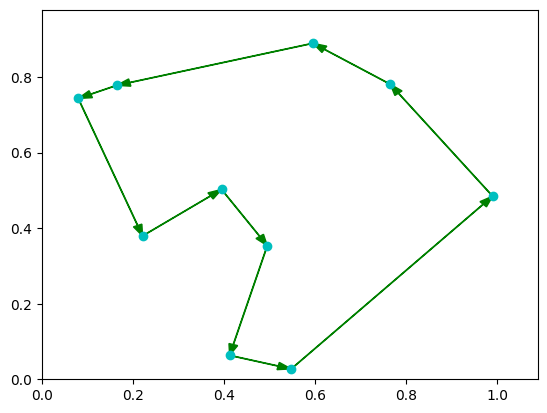

2.969833562603048

In [ ]:
plotTSP(route_def.astype(int), city, 1)
calc_dist_route(city[route_def.astype(int)])

In [ ]:
route_def.astype(int)

array([5, 9, 7, 6, 3, 0, 1, 8, 4, 2])



---


## Questão (a)

Os hiperparâmetros $A$, $B$, $C$ e $D$ são utilizados para definir a superfície de energia $E$, sendo esse o espaço de estados não linear por onde a trajetória do sistema dinâmico da rede de Hopfield irá percorrer durante sua relaxação até que haja a convergência para um mínimo local onde o estado do sistema dinâmico no mesmo guarda as informações da solução do problema. Dessa forma, os hiperparâmetros desempenham o papel de restringir as condições de existência e os critérios de otimização do problema do caixeiro viajante, onde o termo $A$ restringe que uma cidade seja visitada apenas uma vez, o termo $B$ que somente uma cidade pode ser visitada de cada vez, já o termo $C$ penaliza caso o caixeiro passe por mais de $N$ cidades, reforçando junto de $A$, e o termo $D$ mede o percurso percorrido, buscando minimizar a distância total.


## Questão (b)

A superfície de energia que é definida como espaço de estados da máquina, é comumente multimodal, ou seja, possuí mais de um mínimo e com isso, detêm várias bacias de atração. A bacia de atração para qual a trajetória do sistema dinâmico não linear irá convergir é dada pela condição inicial da rede neural, logo, é aleatória. Dessa forma, as condições iniciais de muitos casos podem levar à bacias de atração de mínimos locais ruins, ou até mesmo à pontos de equilíbrio de atratores espúrios, que podem surgir durante a construção de pontos de equilíbrio desejados na superfície de energia.

## Questão (c)

A resolução do problema do caixeiro viajante pela rede de Hopfield, mesmo que apresente uma complexidade menor e uma eficiência maior, devido à mudança do paradigma de computação utilizado, não garante que a solução encontrada será ótima. Dessa forma, mesmo restringindo às condições de existência e penalizando o aumento da distância, a solução ainda que factível pode não ser ótima e sua qualidade depende substancialmente dos hiperparâmetros $A$, $B$, $C$, e $D$ utilizados para construir a máquina.